# Imports

In [ ]:
from catboost import CatBoostRegressor, EFstrType, Pool, sum_models
import gc
import h5py
import joblib
import json
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import os
import pandas as pd
import pickle
import polars as pl
import sys

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from tqdm import tqdm

In [2]:
sys.path.append('../src/')
import h5_utils
from train import drop_target_nan

# Configs

In [8]:
settings_path = '../configs/settings.json'
with open(settings_path, 'r') as f:
    config = json.load(f)

In [9]:
folder_daily_h5 = f"../{config['RAW_DATA_DIR']}/daily/"

metadata_filename = 'metadata.h5'
metadata_filepath = f"../{config['RAW_DATA_DIR']}/{metadata_filename}"

optuna_all_feat_filename = 'optuna_all_sliding.pkl'
optuna_all_feat_filenpath = f"../{config['RAW_DATA_DIR']}/{optuna_all_feat_filename}"

In [10]:
DAY_TEST_START = 400 # train size in day terms

# Daily load trick

In [11]:
date_ids = h5_utils.load_metadata(metadata_filepath)
len(date_ids)

481

# Validation splits

In [7]:
max_train_size = 70
slide_step= max_train_size
n_samples=len(date_ids)

effective_train_size = max_train_size + gap
n_splits = (n_samples - test_size) // (effective_train_size + test_size) + 1
print(n_splits)
tscv = TimeSeriesSplit(n_splits=n_splits,
                max_train_size=max_train_size, 
                test_size=test_size, 
                gap=gap)


In [8]:
class SlidingWindowSplit:
    def __init__(self, 
                 data, 
                 train_days, 
                 #test_days, 
                 slide_step=1):
        self.data = data
        self.train_days = train_days
        self.slide_step = slide_step

    def __iter__(self):
        for i in range(self.train_days, len(self.data) + 1, self.slide_step):
            yield np.arange(i - self.train_days, i)

    def __len__(self):
        return (len(self.data) - self.train_days + 1) // self.slide_step

In [9]:
batch_ids = SlidingWindowSplit(date_ids, 
                       max_train_size, 
                       slide_step)

In [ ]:
for i, train_index in enumerate(tqdm(batch_ids, 
                                    desc="Training and Validation")):
    
    print(f"Batch {i}:")
    print(f"  Train: index={train_index}")

# Intermediate optuna on Catboost for feature selection

## Trial

In [12]:
def params_catboost(trial):
    
    param = {
        "loss_function" : "MAE",
        "eval_metric" : "MAE",
        "iterations" : 1000,  
        #"used_ram_limit": "14gb",
        #"learning_rate": trial.suggest_float("learning_rate", 
        #                              0.2, 0.9), # will optimize it later, catboost has good inner mechanism of choice
        "depth": trial.suggest_int("depth", 5, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 
                                      3, 50),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", 
                             ["Bayesian", "Bernoulli", "MVS"])
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 
                                                 1, 20)
        
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 
                                         0.1, 0.8)
    return param

In [13]:
def batch_learning(param, train_ids):
    '''All the data with such number of features can't fit in memory so we will update model by batches learning'''
    batches = SlidingWindowSplit(train_ids, 
                           max_train_size, 
                           slide_step)

    model_prev = None

    for batch_ind in tqdm(batches, desc="Batch training:"):
        batch_train_days = date_ids[batch_ind]
        
        # Load training data
        train_data, train_labels = h5_utils.stacked_daily_data(batch_train_days,
                                                              folder_daily_h5)

        # Preprocess
        ## Target handle NaNs
        train_data, train_labels = drop_target_nan(train_data, 
                                                   train_labels)

        batch = Pool(train_data, 
                     label=train_labels)

        model_new = CatBoostRegressor(**param, thread_count=-1, random_seed=42)
        if model_prev is None:
            model_new.fit(X=batch, verbose=1)
            model_prev = model_new
        else:
            # https://catboost.ai/en/docs/concepts/python-usages-examples#batch-training
            batch.set_baseline(model_prev.predict(batch))
            model_new.fit(X=batch, verbose=0)
            model_prev = sum_models([model_prev,model_new])
        
    return model_prev

In [14]:
def objective(trial):
    # CV
    train_ids = date_ids[:DAY_TEST_START]
    test_ids = date_ids[DAY_TEST_START:]
    
    param = params_catboost(trial)
    # Train
    final_model = batch_learning(param, train_ids)

    # Score
    ## Load validation data
    valid_data, valid_labels = h5_utils.stacked_daily_data(test_ids,
                                                          folder_daily_h5)
    ## NaN in target is not scored by the rules
    valid_data, valid_labels = drop_target_nan(valid_data, 
                                               valid_labels)
    valid_preds = final_model.predict(valid_data)
    ## Calculate metric
    mae = mean_absolute_error(valid_labels, valid_preds)
    return mae

## Search

In [ ]:
%%time

hours = 10

study = optuna.create_study(direction='minimize',
                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, 
               n_trials=120,
               timeout = 60*60*hours
              )
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Batch training::  50%|█████     | 2/4 [19:46<19:44, 592.18s/it]

In [20]:
print("Best trial: score {}, params {}".format(study.best_trial.value, 
					       study.best_trial.params))

Best trial: score 0.6486779503958122, params {'depth': 8, 'l2_leaf_reg': 22, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7294503489264281}


In [21]:
len(study.trials)

5

## Store study (optional)

In [ ]:
joblib.dump(study, optuna_all_feat_filenpath)

## Observe hyper importances

In [10]:
study = joblib.load(optuna_all_feat_filenpath)

optuna.visualization.plot_param_importances(study)

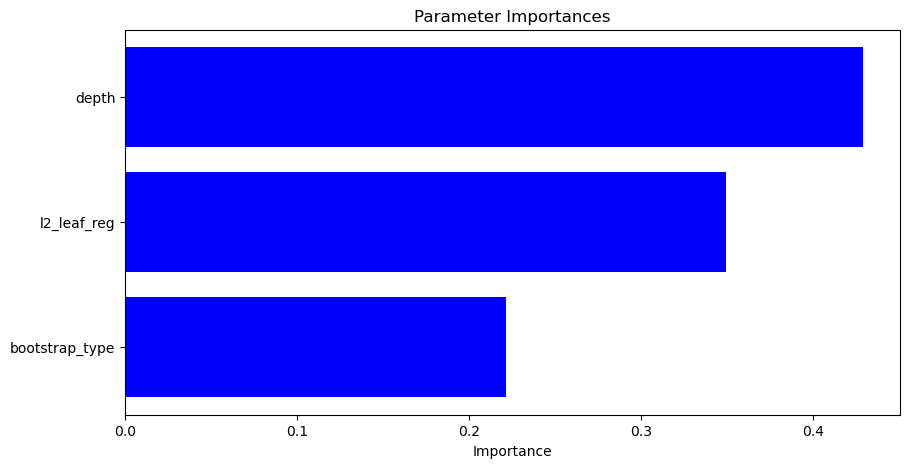

In [15]:
# Get parameter importances
param_importances = optuna.importance.get_param_importances(study)

# Prepare data for visualization
names = list(param_importances.keys())
values = list(param_importances.values())

# Create bar plot
plt.figure(figsize=(10, 5))
plt.barh(names, values, color='blue')
plt.xlabel('Importance')
plt.title('Parameter Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
plt.show()

# Selection

300 features
1) exprimentaly can be fited on kaggle as one batch
2) can satify time limit to be retrained multiple times during test inference

## Best model fit

In [67]:
gc.collect()

0

In [ ]:
%%time
data_train = date_ids[:DAY_TEST_START]
best_model = batch_learning(study.best_trial.params,
                            data_train)

## Store best on all features (optional)

In [59]:
best_model.save_model('Batched_all_feats_444',
           format="cbm")

## Catboost importance approach

In [4]:
feature_importance_catboost2 = best_model.get_feature_importance(type=EFstrType.FeatureImportance, 
				   prettified=True, 
				   thread_count=-1, 
				   verbose=True)

In [5]:
feature_importance_catboost2

,Feature Id,Importances
0,417,45.573726
1,422,10.172564
2,440,5.515918
3,191,4.313303
4,442,3.461714
...,...,...
438,181,0.001182
439,185,0.000999
440,184,0.000941
441,75,0.000112


## Feature names from h5

In [12]:
date_id=date_ids[-1]
filepath=f'{folder_daily_h5}/{date_id}.h5'
with h5py.File(filepath, 'r') as f:
    # Load the target column
    target = f['data']['target'][:]

    features_group = f['data']['features']
    feature_names = list(features_group.keys())

In [13]:
feature_names[:5]

['ask_auc_money',
 'ask_money',
 'ask_price',
 'ask_price_diff_1',
 'ask_price_diff_10']

## Bar plot of top n

In [16]:
feature_id_to_name = {str(id): name for id, name in enumerate(feature_names)}

feature_importance_catboost2['Feature'] = feature_importance_catboost2['Feature Id'].map(feature_id_to_name)

top_n = 15
top_features = feature_importance_catboost2.head(top_n)
top_features

,Feature Id,Importances,Feature
0,417,45.573726,target_mock
1,422,10.172564,target_single
2,440,5.515918,wap_shift_n6
3,191,4.313303,index_target_mock
4,442,3.461714,weight_tmp
5,393,1.865730,seconds_in_bucket
6,439,1.397131,wap_shift_n3
7,145,0.751377,global_rolling18_mean_imb1_reference_price_wap
8,428,0.660389,wap
9,391,0.509950,scale_imbalance_size


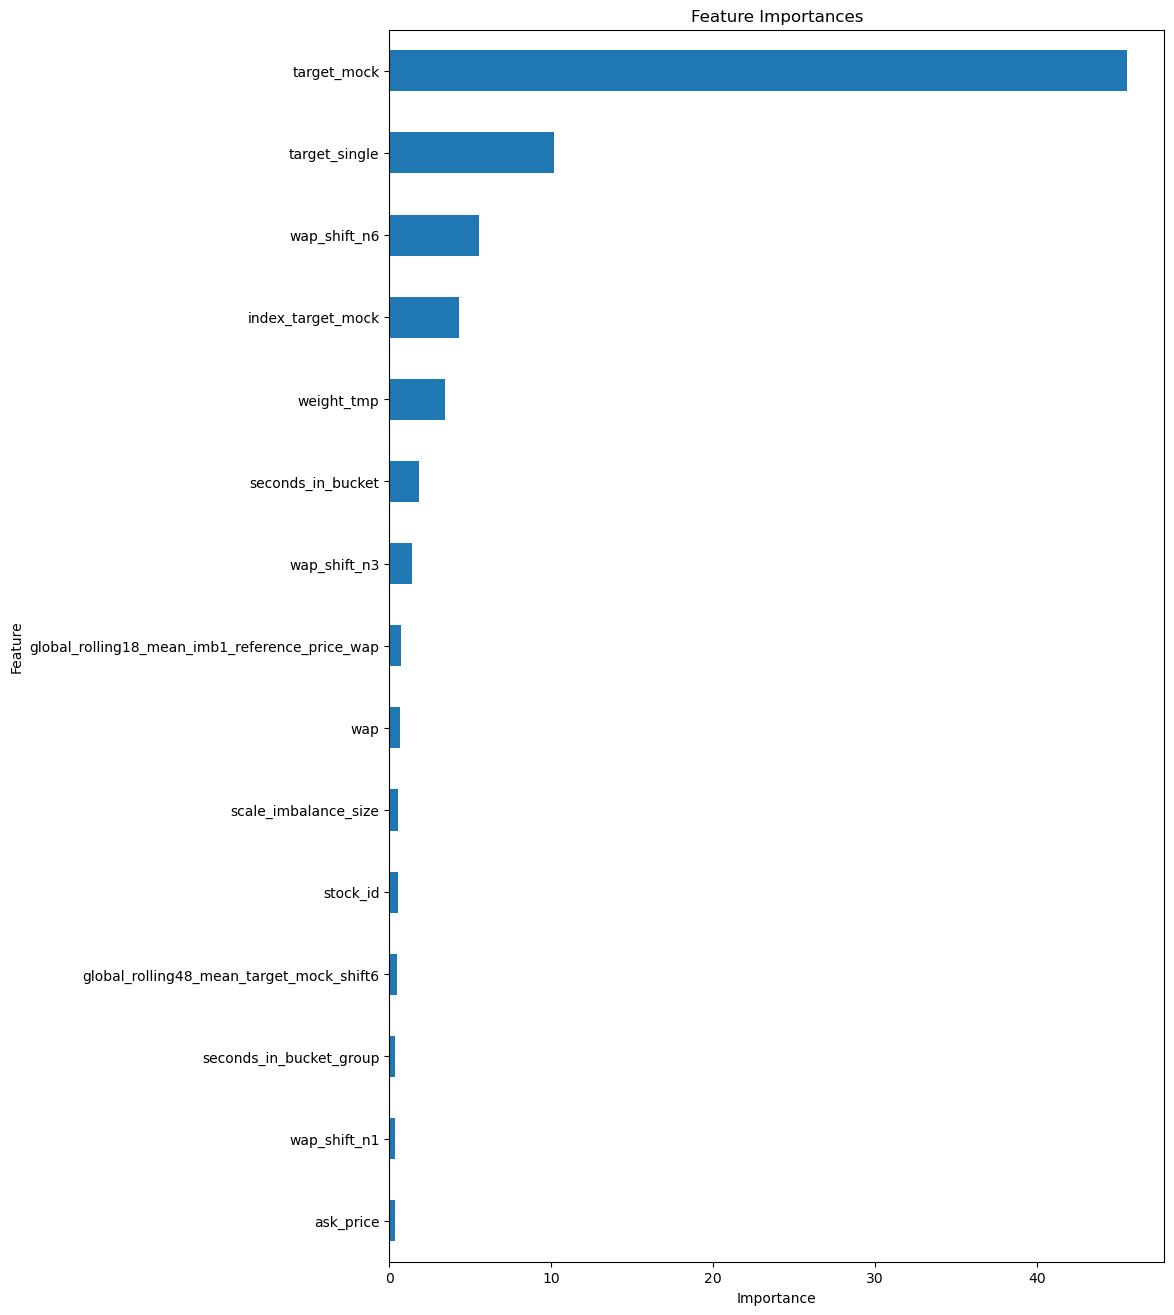

In [17]:
ax = top_features.plot(kind='barh', 
                       x='Feature', 
                       y='Importances', 
                       figsize=(10, 16), 
                       legend=False)

plt.gca().invert_yaxis()

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Seconds in bucket group is one of the top-15 features

In [61]:
top_features = feature_importance_catboost2.head(300)
top_feature_names = top_features['Feature'].tolist()

top_feature_names[:5]

['target_mock',
 'target_single',
 'wap_shift_n6',
 'index_target_mock',
 'weight_tmp']

In [62]:
len(top_feature_names)

300

In [66]:
with open(f"../{config['MODEL_DIR']}/top_300_feats_nms.pkl", 'wb') as f:
    pickle.dump(top_feature_names, f)